## Importing All Required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras_tuner import RandomSearch
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. Nabil Bank (nabil) Stock Price Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/MSc. Dissertation/Dataset/nabil.csv')

In [5]:
df.head()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.0,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.0,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.0,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.0,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.0,352,"393,534.00"


In [6]:
df.tail()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"
3082,9/25/2024,550,560,545.1,555,0.27,"50,441.00","27,867,328.70"


In [7]:
df

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.00,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.00,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.00,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.00,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.00,352,"393,534.00"
...,...,...,...,...,...,...,...,...
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"


In [8]:
df.duplicated().sum()

1

## Copying the dataset for future use

In [9]:
df1 = df.copy()
df1.reset_index(inplace=True)

### Dropping unwanted column

In [10]:
df.drop(['% Change', 'Turnover'], axis=1, inplace=True)
df = df.rename(columns = {
    'Ltp': 'Close',
    'Qty': 'Volume'
})

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float).astype(int)
df

,Date,Open,High,Low,Close,Volume
0,2011-03-20,1200.0,1190.0,1160.0,1170.0,853
1,2011-03-24,1162.0,1178.0,1150.0,1153.0,356
2,2011-03-25,1153.0,1174.0,1145.0,1174.0,702
3,2011-03-27,1174.0,1160.0,1120.0,1147.0,1426
4,2011-03-28,1147.0,1150.0,1110.0,1132.0,352
...,...,...,...,...,...,...
3078,2024-09-18,562.0,565.0,550.0,556.0,68886
3079,2024-09-22,556.0,578.0,556.0,562.0,55026
3080,2024-09-23,573.2,573.2,555.0,568.0,123568
3081,2024-09-24,567.0,567.0,552.1,553.5,66337


### Splitting into features and target

In [12]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [13]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [14]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [15]:
sequence_length = 30
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

In [16]:
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

### Splitting the data into train and test set

In [17]:
# Splitting the first 80% data as training set and rest 20% as test set
X_train, X_test, y_train, y_test = X[:round(X.shape[0]*0.8)], X[round(X.shape[0]*0.8):], y[:round(y.shape[0]*0.8)], y[round(y.shape[0]*0.8):]
_, y_test_indices = target_index[:round(len(target_index)*0.8)], target_index[round(len(target_index)*0.8):]

### Model Building using CNN

In [18]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                  hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='mean_squared_error', metrics=['mse', 'mae'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='stock_price_tuning',
    project_name='cnn_stock_price')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Trial 10 Complete [00h 01m 08s]
val_loss: 0.00039342268428299576

Best val_loss So Far: 0.0002028918024734594
Total elapsed time: 00h 12m 56s


In [19]:
best_model = tuner.get_best_models(num_models=1)[0]

In [20]:
# Make predictions on the test set
predictions = best_model.predict(X_test)
predictions.flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


array([0.28598052, 0.2861207 , 0.28032768, 0.27531832, 0.2748759 ,
       0.27198955, 0.27319992, 0.27176324, 0.27019402, 0.27028808,
       0.27192423, 0.2681319 , 0.2641748 , 0.26132086, 0.25684184,
       0.2559309 , 0.25248325, 0.255398  , 0.25443244, 0.2591778 ,
       0.26490533, 0.2699266 , 0.27160853, 0.27085423, 0.2718765 ,
       0.2681643 , 0.2640323 , 0.26236242, 0.26176265, 0.25994426,
       0.25627184, 0.24921075, 0.2498658 , 0.24058947, 0.23770621,
       0.23268154, 0.23098339, 0.22803196, 0.22894683, 0.22777638,
       0.22353965, 0.22627534, 0.22221673, 0.22487846, 0.22487554,
       0.22609343, 0.22163625, 0.22310983, 0.21926324, 0.21960464,
       0.2151508 , 0.21097547, 0.2081296 , 0.20770058, 0.20588799,
       0.20751771, 0.20882757, 0.2076553 , 0.20877187, 0.20771216,
       0.20801392, 0.2078194 , 0.20613769, 0.20740655, 0.20578174,
       0.20497707, 0.20427786, 0.2007855 , 0.19777775, 0.19447592,
       0.19010748, 0.18722688, 0.18332492, 0.18059252, 0.17944

In [21]:
y_test

array([0.28221649, 0.27491409, 0.27706186, 0.27856529, 0.27727663,
       0.270189  , 0.26589347, 0.26546392, 0.25085911, 0.24952749,
       0.25339347, 0.25167526, 0.25601375, 0.28221649, 0.28780069,
       0.28221649, 0.2757732 , 0.27405498, 0.27061856, 0.26975945,
       0.26847079, 0.26546392, 0.25687285, 0.25558419, 0.25214777,
       0.25085911, 0.24914089, 0.24699313, 0.24699313, 0.24140893,
       0.23324742, 0.23496564, 0.23582474, 0.23109966, 0.23582474,
       0.23582474, 0.22938144, 0.22637457, 0.22250859, 0.22036082,
       0.22744845, 0.22289519, 0.22160653, 0.22031787, 0.21735395,
       0.21391753, 0.20919244, 0.20614261, 0.20060137, 0.20382302,
       0.20949313, 0.21950172, 0.21821306, 0.20962199, 0.21134021,
       0.20876289, 0.20790378, 0.20489691, 0.20408076, 0.20532646,
       0.20472509, 0.20446735, 0.20103093, 0.19458763, 0.1911512 ,
       0.18896048, 0.18170103, 0.18213058, 0.17590206, 0.18084192,
       0.18230241, 0.18303265, 0.18213058, 0.17890893, 0.17310

In [22]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [23]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df.index:
        if a == b:
            prediction['Date'] = df['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2022-02-17,1079.0,1087.762573
2022-02-20,1062.0,1088.088989
2022-02-21,1067.0,1074.602783
2022-02-22,1070.5,1062.941040
2022-02-23,1067.5,1061.911133
...,...,...
2024-09-18,556.0,580.022400
2024-09-22,562.0,600.587708
2024-09-23,568.0,587.891663


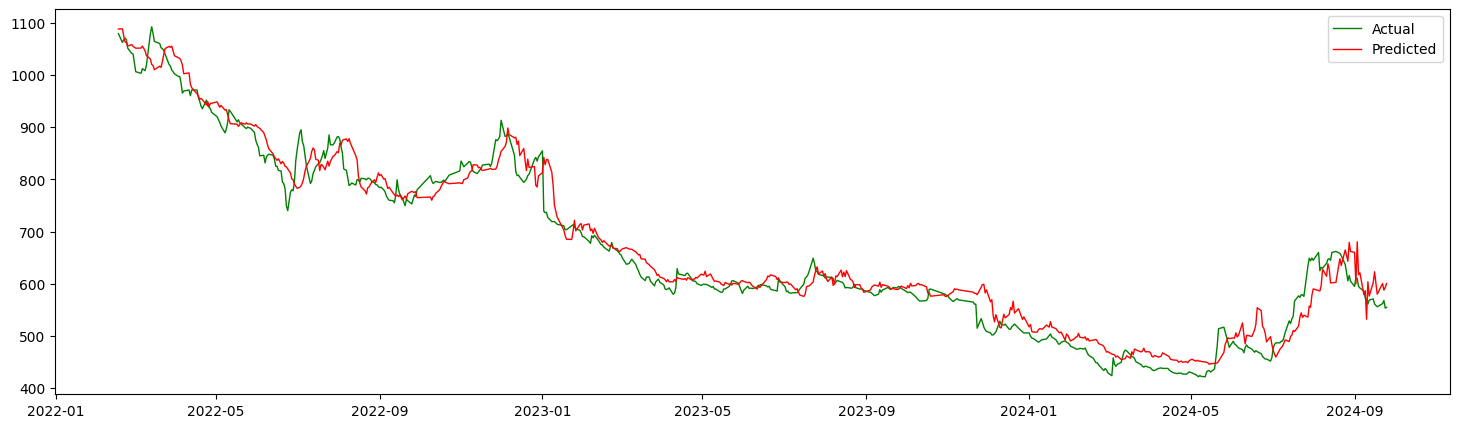

In [24]:
plt.figure(figsize=(18, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.legend()
plt.show()

## Calculating the Performance Evaluation Metrics

In [25]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.00018685209709990057
Root Mean Squared Error: 0.01366938539583622
Mean Absolute Error: 0.010595342466367024


In [26]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 1012.6604768138892
Root Mean Squared Error: 31.822326703336593
Mean Absolute Error: 24.665955249143312
